# Counting Crowds with Deep Learning
## Proof Of Concept

The notebook will implement various papers for the puprose of crowd counting
* [Dense Scale Networks](https://arxiv.org/pdf/1906.09707.pdf)
* [CSRNet: Dilated Convolutional Neural Networks](https://arxiv.org/pdf/1802.10062.pdf)

The goal - to find the best approach to teach a model to count crowds, based on input images.

## 1. Imports

In [1]:
import os
import cv2
import glob
import random
import numpy as np
import scipy.io
import h5py
import collections
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
from skimage import exposure, img_as_float
import logging
import warnings
warnings.filterwarnings("ignore")

In [2]:
# reporting module
from ovreport.report import report_to_overwatch

### 1.1 Globals
A number of parameters on top of the notebook

In [5]:
# Dataset Paths
train_path_UCF_QNRF = 'training_dataset/UCF-QNRF_ECCV18/Train_h5/'
test_path_UCF_QNRF = 'training_dataset/UCF-QNRF_ECCV18/Test_h5/'
# TODO: Add More ... add more

# Target Image Size
TARGET_SHAPE = (720, 480)

# Model save paths
BEST_MODEL_SAVE_PATH = 'models/best/'
CKP_MODEL_SAVE_PATH = 'models/checkpoints/'
# Training Details
PRETRAINED_BACKBONE = True
TRAIN_BATCH_SIZE = 1
TEST_BATCH_SIZE = 1
EPOCHS = 100
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 5e-4

### 1.2 Dealing with Data

In [6]:
class RawDataset(Dataset):
    def __init__(self, root, transform, ratio=8, output_shape=False, aug=False):
        self.nsamples = len(root)
        self.aug = aug
        self.output_shape = output_shape
        self.root = root
        self.ratio = ratio
        self.transform = transform
    
    def __augment(image, target, count, seed):
        random.seed(seed)
        
        # apply random crop
        if random.random() < 0.5:
            crop_size = (img.size[0]//2, img.size[1]//2)
        
            if random.random() <=0.44:
                # 4 non-overlapping patches
                dx = int(random.randint(0,1) * crop_size[0])
                dy = int(random.randint(0,1) * crop_size[1])
            else:
                # 5 random patches
                # set seed to ensure for each image the random patches are certain
                # if not set, the crop will be online which means the patches change every time loading, leading to a dynamic training set.
                patch_id = random.randint(0, 4)
                random.seed(index + patch_id * 0.1)
                dx = int(random.random() * crop_size[0])
                random.seed(index + 0.5 + patch_id * 0.1)
                dy = int(random.random() * crop_size[1])
            # crop
            img = img.crop((dx, dy, crop_size[0]+dx, crop_size[1]+dy))
            target = target[dy:crop_size[1]+dy, dx:crop_size[0]+dx]
            count = float(target.sum())
        
        if random.random() > 0.5:
            target = np.fliplr(target)
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
        
        if random.random() > 0.7:
            img = img_as_float(image)
            # gamma_img: np.array(dtype=float64) ranging [0,1]
            if random.random() > 0.5:
                gamma_img = exposure.adjust_gamma(img, 1.5)
            else:
                gamma_img = exposure.adjust_gamma(img, 0.5)
            gamma_img = gamma_img * 255
            gamma_img = np.uint8(gamma_img)
            image = Image.fromarray(gamma_img)
        
        return image, target, count
    
    def __resize_to_target(self, img, target_shape):
        return cv2.resize(img, target_shape, interpolation=cv2.INTER_CUBIC)
    
    def __load_data(self, path, ratio=8, output_shape=None, aug=False, index=None):
        src_h5 = h5py.File(path, 'r')
        img = src_h5['image_array'].value
        output = src_h5['density_map'].value
        count = float(src_h5['count'].value)


        if len(img.shape) < 3:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        if output_shape is not None:
            img = self.__resize_to_target(img, output_shape)
            output = self.__resize_to_target(output, output_shape)

        if aug:
            # TODO: Implement augumentation
            img, output, count = self.__augment(img, output, count, 42)

        if self.ratio>1:
            output = cv2.resize(output, 
                                (int(output.shape[1]/ratio),int(output.shape[0]/ratio)), 
                                interpolation=cv2.INTER_CUBIC) * (ratio**2)

        output = np.reshape(output, (1, ) + output.shape)

        return img, output, count        
    
    def __getitem__(self, index):
        img, target, count = self.__load_data(self.root[index], output_shape=self.output_shape, aug=self.aug)
        if self.transform:
            img = self.transform(img)
        return img, target, count
    def __len__(self):
        return self.nsamples

In [7]:
def get_loaders(train_path, test_path, output_shape, ratio=8):
    train_img_paths = glob.glob(os.path.join(train_path, '*.h5'))
    test_img_paths = glob.glob(os.path.join(test_path, '*.h5'))
    
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    train_dataset = RawDataset(train_img_paths, transform, ratio=ratio, output_shape=output_shape, aug=False)
    test_dataset = RawDataset(test_img_paths, transform, ratio=ratio, output_shape=output_shape, aug=False)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=TRAIN_BATCH_SIZE)
    test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=TEST_BATCH_SIZE)
    
    return train_loader, test_loader

In [8]:
train_loader, test_loader = get_loaders(train_path_UCF_QNRF, test_path_UCF_QNRF, output_shape=TARGET_SHAPE)
train_loader2, test_loader2 = get_loaders(train_path_UCF_QNRF, test_path_UCF_QNRF, output_shape=TARGET_SHAPE, ratio=1)

### 1.3 Utilities

#### 1.3.1 Model Checkpoints
Save model checkpoints, which are - epoch number, model state and optimizer state. A model checkpoint will be saved only whenever a better MAE is achieved or each 5 epochs, only if the previous loss has been improved.

In [9]:
def save_checkpoint(epoch, model_filename, model_state_dict, optimizer_state_dict, save_path):
    '''
        Saves the model, as well as the optimizer state in the predefined place.
    '''
    print('Saving Model!')
    checkpoint = {
        'epoch': epoch,
        'state_dict': model_state_dict,
        'optimizer': optimizer_state_dict
    }
    
    torch.save(checkpoint, os.path.join(save_path, model_filename))

In [10]:
def load_checkpoint(checkpoint_filepath):
    '''
        Loads the model from checkpoint_filepath.
    '''    
    return torch.load(checkpoint_filepath)

## 2. Dense Scale Network

### 2.1 The Model

In [9]:
class DDCB(nn.Module):
    '''
        TODO: Docstring
    '''
    def __init__(self, in_planes):
        super(DDCB, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_planes, 256, 1), nn.ReLU(True), 
                                   nn.Conv2d(256, 64, 3, padding=1), nn.ReLU(True))
        self.conv2 = nn.Sequential(nn.Conv2d(in_planes+64, 256, 1), nn.ReLU(True), 
                                   nn.Conv2d(256, 64, 3, padding=2, dilation=2), nn.ReLU(True))
        self.conv3 = nn.Sequential(nn.Conv2d(in_planes+128, 256, 1), nn.ReLU(True), 
                                   nn.Conv2d(256, 64, 3, padding=3, dilation=3), nn.ReLU(True))
        self.conv4 = nn.Sequential(nn.Conv2d(in_planes+128, 512, 3, padding=1), nn.ReLU(True))
    def forward(self, x):
        x1_raw = self.conv1(x)
        x1 = torch.cat([x, x1_raw], 1)
        x2_raw = self.conv2(x1)
        x2 = torch.cat([x, x1_raw, x2_raw], 1)
        x3_raw = self.conv3(x2)
        x3 = torch.cat([x, x2_raw, x3_raw], 1)
        output = self.conv4(x3)
        return output

In [10]:
class DenseScaleNet(nn.Module):
    '''
        TODO: Docstring
    '''
    def __init__(self, model_state='', pretrained_backbone=False, trainable_backbone=False):
        super(DenseScaleNet, self).__init__()
        self.model_state = model_state
        self.pretrained_backbone = pretrained_backbone
        self.trainable_backbone = trainable_backbone
        # network
        self.features = self.__get_backbone()
        self.DDCB1 = DDCB(512)
        self.DDCB2 = DDCB(512)
        self.DDCB3 = DDCB(512)
        self.output_layers = nn.Sequential(nn.Conv2d(512, 128, 3, padding=1), 
                                           nn.ReLU(True), 
                                           nn.Conv2d(128, 64, 3, padding=1), 
                                           nn.ReLU(True), 
                                           nn.Conv2d(64, 1, 1))
        self.__initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x1_raw = self.DDCB1(x)
        x1 = x1_raw + x
        x2_raw = self.DDCB2(x1)
        x2 = x2_raw + x1_raw + x
        x3_raw = self.DDCB3(x2)
        x3 = x3_raw + x2_raw + x1_raw + x
        output = self.output_layers(x3)
        return output
    
    def __get_backbone(self):
        self.features_cfg = [64, 64, 'M', 
                             128, 128, 'M', 
                             256, 256, 256, 'M', 
                             512, 512, 512,]
        return self.__make_layers(self.features_cfg)
    
    def __make_layers(self, cfg, in_channels=3, batch_norm=False, dilation=False):
        if dilation:
            d_rate = 2
        else:
            d_rate = 1
        layers = []
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)   
    
    def __initialize_weights(self):
        self_dict = self.state_dict()
        pretrained_dict = dict()
        self.__random_initialize_weights()
        if not self.model_state:
            # load vgg16
            vgg16 = torchvision.models.vgg16(pretrained=self.pretrained_backbone)
            # check if the backbone should be trainable or not
            if not self.trainable_backbone:
                for param in vgg16.parameters():
                    param.requires_grad = False
            # copy over the items that match        
            for k, v in vgg16.state_dict().items():
                if k in self_dict and self_dict[k].size() == v.size():
                    pretrained_dict[k] = v
            self_dict.update(pretrained_dict)
            self.load_state_dict(self_dict)
        else:
            self_dict.update(self.model_state)
            self.load_state_dict(self_dict)
            
    def __random_initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight, std=0.01)
                #nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

### 2.2 Criterion, Loss

In [11]:
criterion = nn.MSELoss()

In [12]:
def cal_lc_loss(output, target, sizes=(1,2,4)):
    criterion_L1 = nn.L1Loss()
    Lc_loss = None
    for s in sizes:
        pool = nn.AdaptiveAvgPool2d(s)
        est = pool(output)
        gt = pool(target)
        if Lc_loss:
            Lc_loss += criterion_L1(est, gt)
        else:
            Lc_loss = criterion_L1(est, gt)
    return Lc_loss

In [13]:
def calc_loss(output, target):
    Le_Loss = criterion(output, target)
    Lc_Loss = cal_lc_loss(output, target)
    loss = Le_Loss + 1000 * Lc_Loss
    return loss

In [14]:
def val(model, test_loader):
    model.eval()
    mae = 0.0
    mse = 0.0
    with torch.no_grad():
        for img, target, count in test_loader:
            img = img.cuda()
            output = model(img)
            est_count = output.sum().item()
            mae += abs(est_count - count)
            mse += (est_count - count)**2
    mae /= len(test_loader)
    mse /= len(test_loader)
    mse = mse**0.5
    return float(mae), float(mse)

### 2.3 Init Model
Or load a pretrained one.

In [15]:
chkp = load_checkpoint('models/best/DenseScaleNet_noaug_1e-5.pth')
dsn_net_weights = chkp['state_dict']

In [16]:
dsn_net = DenseScaleNet(dsn_net_weights, pretrained_backbone=True, trainable_backbone=True)
dsn_net.cuda()

DenseScaleNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, 

### 2.4 Optimizer

In [17]:
optimizer = torch.optim.Adam(dsn_net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

### 2.5 Training Loop

In [18]:
def train_model(model, train_loader, test_loader, optimizer):
    '''
        TODO: Docstring
    '''
    best_mae, _  = val(model, test_loader)
    
    for epoch in range(EPOCHS):
        train_loss = 0.0
        model.train()
        for img, target, count in tqdm(train_loader):
            optimizer.zero_grad()
            img = img.cuda()
            target = target.float()
            target = target.cuda()
            output = model(img)

            loss = calc_loss(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        mae, mse = val(model, test_loader)

        print('Epoch {}/{} Loss:{:.3f}, MAE:{:.2f}, MSE:{:.2f}, Best MAE:{:.2f}'.format(epoch+1, 
                                                                                        EPOCHS, 
                                                                                        train_loss/len(train_loader), 
                                                                                        mae, 
                                                                                        mse, 
                                                                                        best_mae))
        if epoch + 1 % 5 == 0:
            save_checkpoint(epoch, f'DenseScaleNet_noaug_e{epoch}_{LEARNING_RATE}.pth', 
                            model.state_dict(), 
                            optimizer.state_dict(), 
                            CKP_MODEL_SAVE_PATH)          
        
        if mae < best_mae:
            best_mae = mae
            print(f'New best mae: {best_mae}. Saving model!')
            # report best model
            report_to_overwatch('VM:ML:P', 'Atlas', f'Epoch {epoch} recorded {best_mae}!')
            
            save_checkpoint(epoch, 'DenseScaleNet_noaug_1e-5.pth', 
                            model.state_dict(), 
                            optimizer.state_dict(), 
                            BEST_MODEL_SAVE_PATH)
    
    return model

### 2.6 Training the model

In [19]:
dsn_net = train_model(dsn_net, train_loader, test_loader, optimizer)
report_to_overwatch('VM:ML:P', 'Atlas', 'Training of model done!')

  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 1/100 Loss:34.557, MAE:624.50, MSE:917.24, Best MAE:608.87


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 2/100 Loss:33.237, MAE:610.13, MSE:918.27, Best MAE:608.87


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 3/100 Loss:33.887, MAE:631.61, MSE:937.98, Best MAE:608.87


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 4/100 Loss:32.704, MAE:626.16, MSE:931.62, Best MAE:608.87


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 5/100 Loss:28.984, MAE:631.08, MSE:933.77, Best MAE:608.87


100%|██████████| 1200/1200 [11:32<00:00,  1.73it/s]


Epoch 6/100 Loss:30.980, MAE:594.59, MSE:902.63, Best MAE:608.87
New best mae: 594.590464276468. Saving model!
200
Report sent
Saving Model!


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 7/100 Loss:29.651, MAE:612.82, MSE:918.76, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 8/100 Loss:28.802, MAE:637.28, MSE:946.32, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 9/100 Loss:26.242, MAE:626.87, MSE:919.65, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 10/100 Loss:26.670, MAE:607.95, MSE:913.09, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 11/100 Loss:28.138, MAE:610.42, MSE:909.84, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 12/100 Loss:26.272, MAE:667.42, MSE:973.87, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 13/100 Loss:25.437, MAE:639.42, MSE:944.59, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 14/100 Loss:27.469, MAE:619.54, MSE:920.40, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 15/100 Loss:23.905, MAE:657.71, MSE:956.07, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 16/100 Loss:23.659, MAE:645.84, MSE:954.86, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 17/100 Loss:23.370, MAE:603.86, MSE:904.66, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 18/100 Loss:25.051, MAE:608.84, MSE:911.55, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 19/100 Loss:21.702, MAE:635.64, MSE:941.95, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 20/100 Loss:21.305, MAE:646.48, MSE:949.51, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 21/100 Loss:22.572, MAE:619.98, MSE:923.96, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 22/100 Loss:22.316, MAE:639.89, MSE:950.92, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 23/100 Loss:20.085, MAE:609.34, MSE:909.06, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 24/100 Loss:19.488, MAE:594.66, MSE:896.32, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 25/100 Loss:20.870, MAE:602.96, MSE:906.46, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 26/100 Loss:21.278, MAE:611.36, MSE:910.29, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 27/100 Loss:20.499, MAE:600.67, MSE:890.25, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 28/100 Loss:18.783, MAE:614.50, MSE:917.01, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 29/100 Loss:19.457, MAE:623.27, MSE:925.43, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 30/100 Loss:18.678, MAE:619.55, MSE:926.16, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 31/100 Loss:18.521, MAE:640.89, MSE:945.09, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 32/100 Loss:16.754, MAE:623.73, MSE:925.52, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 33/100 Loss:19.708, MAE:632.90, MSE:939.98, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 34/100 Loss:16.483, MAE:620.21, MSE:932.10, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 35/100 Loss:17.777, MAE:602.46, MSE:913.69, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 36/100 Loss:17.916, MAE:615.40, MSE:917.86, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 37/100 Loss:16.301, MAE:641.57, MSE:949.90, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 38/100 Loss:16.827, MAE:621.98, MSE:918.73, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 39/100 Loss:16.626, MAE:637.22, MSE:940.63, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 40/100 Loss:16.611, MAE:603.19, MSE:905.76, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 41/100 Loss:17.211, MAE:652.60, MSE:959.16, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 42/100 Loss:17.908, MAE:619.95, MSE:927.51, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 43/100 Loss:15.951, MAE:626.29, MSE:934.84, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 44/100 Loss:16.090, MAE:613.28, MSE:915.19, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 45/100 Loss:15.764, MAE:623.35, MSE:930.55, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 46/100 Loss:15.023, MAE:615.03, MSE:919.00, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 47/100 Loss:14.080, MAE:610.99, MSE:915.44, Best MAE:594.59


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 48/100 Loss:17.564, MAE:613.34, MSE:922.68, Best MAE:594.59


100%|██████████| 1200/1200 [11:32<00:00,  1.73it/s]


Epoch 49/100 Loss:14.351, MAE:587.20, MSE:893.92, Best MAE:594.59
New best mae: 587.1952201763313. Saving model!
200
Report sent
Saving Model!


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 50/100 Loss:13.810, MAE:614.20, MSE:915.70, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 51/100 Loss:13.709, MAE:633.33, MSE:940.98, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 52/100 Loss:14.572, MAE:629.85, MSE:940.18, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 53/100 Loss:15.436, MAE:626.66, MSE:934.35, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 54/100 Loss:13.920, MAE:643.49, MSE:949.28, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 55/100 Loss:15.489, MAE:642.81, MSE:947.06, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 56/100 Loss:14.436, MAE:616.01, MSE:924.97, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 57/100 Loss:13.444, MAE:639.72, MSE:945.32, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 58/100 Loss:15.098, MAE:598.42, MSE:902.83, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 59/100 Loss:12.857, MAE:636.01, MSE:942.73, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 60/100 Loss:11.782, MAE:611.22, MSE:914.13, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 61/100 Loss:13.923, MAE:638.79, MSE:947.94, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 62/100 Loss:13.307, MAE:626.30, MSE:939.19, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 63/100 Loss:12.920, MAE:619.71, MSE:924.57, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 64/100 Loss:12.899, MAE:636.06, MSE:940.31, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 65/100 Loss:12.311, MAE:614.14, MSE:917.18, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 66/100 Loss:12.902, MAE:615.74, MSE:917.09, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 67/100 Loss:12.507, MAE:617.30, MSE:924.46, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 68/100 Loss:12.846, MAE:600.49, MSE:907.85, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 69/100 Loss:13.447, MAE:615.72, MSE:924.86, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 70/100 Loss:12.226, MAE:611.09, MSE:925.05, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 71/100 Loss:11.107, MAE:637.02, MSE:948.34, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 72/100 Loss:12.074, MAE:612.05, MSE:913.68, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 73/100 Loss:10.685, MAE:650.74, MSE:958.95, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 74/100 Loss:12.697, MAE:610.58, MSE:911.20, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 75/100 Loss:13.409, MAE:599.51, MSE:901.61, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 76/100 Loss:11.020, MAE:607.78, MSE:912.77, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 77/100 Loss:12.254, MAE:615.50, MSE:920.89, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 78/100 Loss:10.778, MAE:631.97, MSE:935.47, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 79/100 Loss:11.150, MAE:636.87, MSE:948.50, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 80/100 Loss:12.551, MAE:612.74, MSE:916.30, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 81/100 Loss:11.323, MAE:650.46, MSE:959.31, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 82/100 Loss:11.917, MAE:642.93, MSE:945.78, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 83/100 Loss:11.035, MAE:625.16, MSE:928.58, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 84/100 Loss:12.219, MAE:628.78, MSE:937.38, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 85/100 Loss:10.677, MAE:615.18, MSE:920.59, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 86/100 Loss:10.734, MAE:626.44, MSE:928.23, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 87/100 Loss:12.032, MAE:624.38, MSE:929.09, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 88/100 Loss:11.942, MAE:610.62, MSE:915.79, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 89/100 Loss:10.794, MAE:619.42, MSE:924.59, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 90/100 Loss:10.420, MAE:615.79, MSE:926.53, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 91/100 Loss:10.219, MAE:630.67, MSE:934.74, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 92/100 Loss:10.375, MAE:634.52, MSE:942.85, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 93/100 Loss:10.730, MAE:640.08, MSE:944.33, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 94/100 Loss:9.503, MAE:620.15, MSE:926.79, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 95/100 Loss:9.233, MAE:628.51, MSE:935.68, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 96/100 Loss:10.274, MAE:603.72, MSE:909.73, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 97/100 Loss:10.000, MAE:625.86, MSE:930.18, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 98/100 Loss:10.546, MAE:614.66, MSE:919.34, Best MAE:587.20


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 99/100 Loss:10.810, MAE:609.60, MSE:914.90, Best MAE:587.20


100%|██████████| 1200/1200 [11:32<00:00,  1.73it/s]


Epoch 100/100 Loss:8.986, MAE:607.63, MSE:909.93, Best MAE:587.20
200
Report sent


### 2.7 Testing

In [20]:
img, target, count = next(iter(test_loader))
img = img.cuda()

In [21]:
output = dsn_net(img)

In [22]:
output.sum().item()

5.902300834655762

In [25]:
count

tensor([332.], dtype=torch.float64)

## 3. Congested Scene Recognition Network

### 3.1 The Model

In [11]:
class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.frontend_feat = [64, 64, 'M', 128, 128,
                              'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat = [512, 512, 512, 256, 128, 64]
        self.frontend = self.__make_layers(self.frontend_feat)
        self.backend = self.__make_layers(self.backend_feat, in_channels=512, dilation=True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = torchvision.models.vgg16(pretrained=True)
            self.__initialize_weights()
            fsd = collections.OrderedDict()
            # 10 convlution *(weight, bias) = 20 parameters
            for i in range(len(self.frontend.state_dict().items())):
                temp_key = list(self.frontend.state_dict().items())[i][0]
                fsd[temp_key] = list(mod.state_dict().items())[i][1]
            self.frontend.load_state_dict(fsd)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        x = nn.functional.interpolate(x, scale_factor=8)
        return x

    def __initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def __make_layers(self, cfg, in_channels=3, batch_norm=False, dilation=False):
        if dilation:
            d_rate = 2
        else:
            d_rate = 1
        layers = []
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3,
                                   padding=d_rate, dilation=d_rate)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

### 3.2 Criterion
Same as Dense Scale Net

In [12]:
criterion = nn.MSELoss(size_average=False)

### 3.3 Init Model

In [13]:
csr_net = CSRNet()
csr_net.cuda()

CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

### 3.4 Optimizer

In [14]:
optimizer = torch.optim.Adam(csr_net.parameters(), lr=LEARNING_RATE) 

### 3.5 Train Loop

In [15]:
def train_model(model, optimizer, criterion, train_dataloader, test_dataloader):
    min_mae = 999999
    min_mae_epoch = -1
    for epoch in range(1, EPOCHS):                          # start training
        model.train()
        epoch_loss = 0.0
        for img, target, count in tqdm(train_dataloader):
            image = img.cuda()
            gt_densitymap = target.float()
            gt_densitymap = gt_densitymap.cuda()
            et_densitymap = model(image)  
            loss = criterion(et_densitymap,gt_densitymap)       # calculate loss
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()                                     # back propagation
            optimizer.step()                                    # update network parameters
            
        print('Epoch {}/{} Loss: {:.3f}'.format(epoch, EPOCHS, epoch_loss/len(train_loader)))

        model.eval()
        
        with torch.no_grad():
            epoch_mae = 0.0
            for img, target, count in tqdm(test_dataloader):
                image = img.cuda()
                target = target.float()
                gt_densitymap = target.cuda()
                et_densitymap = model(image).detach()           # forward propagation
                mae = abs(et_densitymap.data.sum()-gt_densitymap.data.sum())
                epoch_mae += mae.item()
            epoch_mae /= len(test_dataloader)
            print('Epoch {}/{} MAE: {:.3f}'.format(epoch, EPOCHS, epoch_mae))
            if epoch_mae < min_mae:
                min_mae, min_mae_epoch = epoch_mae, epoch
                report_to_overwatch('VM:ML:P', 'Atlas', f'Epoch {epoch} recorded {min_mae}!')
                torch.save(model.state_dict(), os.path.join(BEST_MODEL_SAVE_PATH,'CSRNet_'+str(epoch)+".pth")) 

### 3.6 Training the model.

In [16]:
csr_net = train_model(csr_net, optimizer, criterion, train_loader2, test_loader2)
report_to_overwatch('VM:ML:P', 'Atlas', 'Training of CSRNet model done!')

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 1/100 Loss: 1.182


100%|██████████| 334/334 [02:09<00:00,  2.58it/s]


Epoch 1/100 MAE: 233.629
200
Report sent


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 2/100 Loss: 1.192


100%|██████████| 334/334 [02:09<00:00,  2.58it/s]


Epoch 2/100 MAE: 104.593
200
Report sent


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 3/100 Loss: 1.233


100%|██████████| 334/334 [02:09<00:00,  2.58it/s]


Epoch 3/100 MAE: 92.572
200
Report sent


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 4/100 Loss: 1.091


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 4/100 MAE: 144.192


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 5/100 Loss: 1.155


100%|██████████| 334/334 [02:09<00:00,  2.58it/s]


Epoch 5/100 MAE: 89.640


  0%|          | 0/1200 [00:00<?, ?it/s]

200
Report sent


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 6/100 Loss: 1.228


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 6/100 MAE: 98.880


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 7/100 Loss: 1.170


  0%|          | 1/1200 [00:00<02:25,  8.25it/s]

Epoch 7/100 MAE: 294.268


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 8/100 Loss: 1.114


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 8/100 MAE: 99.517


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 9/100 Loss: 1.107


100%|██████████| 334/334 [02:09<00:00,  2.58it/s]


Epoch 9/100 MAE: 83.887
200
Report sent


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 10/100 Loss: 1.160


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 10/100 MAE: 118.140


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 11/100 Loss: 1.096


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 11/100 MAE: 86.957


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 12/100 Loss: 1.084


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 12/100 MAE: 92.533


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 13/100 Loss: 1.056


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 13/100 MAE: 124.865


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 14/100 Loss: 1.055


  0%|          | 1/1200 [00:00<02:57,  6.75it/s]

Epoch 14/100 MAE: 88.601


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 15/100 Loss: 1.022


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 15/100 MAE: 109.510


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 16/100 Loss: 1.002


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 16/100 MAE: 95.959


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 17/100 Loss: 1.062


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 17/100 MAE: 86.191


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 18/100 Loss: 1.886


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 18/100 MAE: 144.106


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 19/100 Loss: 1.086


  0%|          | 1/1200 [00:00<03:04,  6.50it/s]

Epoch 19/100 MAE: 91.036


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 20/100 Loss: 1.028


  0%|          | 1/1200 [00:00<02:24,  8.29it/s]

Epoch 20/100 MAE: 89.317


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 21/100 Loss: 0.999


100%|██████████| 334/334 [02:09<00:00,  2.58it/s]


Epoch 21/100 MAE: 82.242


  0%|          | 0/1200 [00:00<?, ?it/s]

200
Report sent


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 22/100 Loss: 0.957


100%|██████████| 334/334 [02:09<00:00,  2.58it/s]


Epoch 22/100 MAE: 81.125
200
Report sent


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 23/100 Loss: 0.940


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 23/100 MAE: 154.323


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 24/100 Loss: 1.062


  0%|          | 1/1200 [00:00<02:39,  7.52it/s]

Epoch 24/100 MAE: 143.634


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 25/100 Loss: 1.004


  0%|          | 1/1200 [00:00<02:52,  6.95it/s]

Epoch 25/100 MAE: 104.768


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 26/100 Loss: 0.953


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 26/100 MAE: 119.508


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 27/100 Loss: 0.953


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 27/100 MAE: 128.408


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 28/100 Loss: 1.049


100%|██████████| 334/334 [02:09<00:00,  2.58it/s]


Epoch 28/100 MAE: 78.069


  0%|          | 0/1200 [00:00<?, ?it/s]

200
Report sent


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 29/100 Loss: 1.017


  0%|          | 1/1200 [00:00<02:27,  8.12it/s]

Epoch 29/100 MAE: 82.607


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 30/100 Loss: 0.992


  0%|          | 1/1200 [00:00<03:34,  5.58it/s]

Epoch 30/100 MAE: 110.603


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 31/100 Loss: 0.928


100%|██████████| 334/334 [02:09<00:00,  2.58it/s]


Epoch 31/100 MAE: 74.227
200
Report sent


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 32/100 Loss: 0.943


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 32/100 MAE: 116.819


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 33/100 Loss: 0.941


100%|██████████| 334/334 [02:09<00:00,  2.58it/s]


Epoch 33/100 MAE: 69.297
200
Report sent


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 34/100 Loss: 0.915


  0%|          | 1/1200 [00:00<02:36,  7.64it/s]

Epoch 34/100 MAE: 125.073


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 35/100 Loss: 0.887


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 35/100 MAE: 216.984


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 36/100 Loss: 0.954


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 36/100 MAE: 137.067


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 37/100 Loss: 0.977


  0%|          | 1/1200 [00:00<03:46,  5.29it/s]

Epoch 37/100 MAE: 88.059


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 38/100 Loss: 0.887


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 38/100 MAE: 73.664


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 39/100 Loss: 0.878


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 39/100 MAE: 80.577


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 40/100 Loss: 0.914


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 40/100 MAE: 96.934


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 41/100 Loss: 0.867


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 41/100 MAE: 70.573


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 42/100 Loss: 0.858


  0%|          | 1/1200 [00:00<03:43,  5.37it/s]

Epoch 42/100 MAE: 91.741


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 43/100 Loss: 0.882


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 43/100 MAE: 171.972


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 44/100 Loss: 0.848


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 44/100 MAE: 119.137


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 45/100 Loss: 0.865


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 45/100 MAE: 175.815


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 46/100 Loss: 0.928


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 46/100 MAE: 81.263


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 47/100 Loss: 0.894


100%|██████████| 334/334 [02:09<00:00,  2.58it/s]


Epoch 47/100 MAE: 65.485


  0%|          | 0/1200 [00:00<?, ?it/s]

200
Report sent


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 48/100 Loss: 0.828


  0%|          | 1/1200 [00:00<02:52,  6.93it/s]

Epoch 48/100 MAE: 112.034


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 49/100 Loss: 0.834


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 49/100 MAE: 81.076


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 50/100 Loss: 0.812


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 50/100 MAE: 76.101


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 51/100 Loss: 0.805


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 51/100 MAE: 68.487


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 52/100 Loss: 0.841


  0%|          | 1/1200 [00:00<02:41,  7.44it/s]

Epoch 52/100 MAE: 78.129


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 53/100 Loss: 0.778


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 53/100 MAE: 70.188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 54/100 Loss: 0.796


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 54/100 MAE: 249.479


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 55/100 Loss: 0.875


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 55/100 MAE: 70.487


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 56/100 Loss: 0.833


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 56/100 MAE: 72.752


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 57/100 Loss: 0.832


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 57/100 MAE: 91.709


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 58/100 Loss: 0.816


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 58/100 MAE: 82.488


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 59/100 Loss: 0.844


100%|██████████| 334/334 [02:09<00:00,  2.58it/s]


Epoch 59/100 MAE: 61.731
200
Report sent


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 60/100 Loss: 0.760


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 60/100 MAE: 65.124


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 61/100 Loss: 0.782


100%|██████████| 334/334 [02:09<00:00,  2.58it/s]


Epoch 61/100 MAE: 60.287
200
Report sent


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 62/100 Loss: 0.766


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 62/100 MAE: 60.746


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 63/100 Loss: 0.776


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 63/100 MAE: 74.492


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 64/100 Loss: 0.744


  0%|          | 1/1200 [00:00<02:43,  7.36it/s]

Epoch 64/100 MAE: 77.719


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 65/100 Loss: 0.746


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 65/100 MAE: 84.088


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 66/100 Loss: 0.788


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 66/100 MAE: 96.819


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 67/100 Loss: 0.752


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 67/100 MAE: 69.568


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 68/100 Loss: 0.741


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 68/100 MAE: 68.607


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 69/100 Loss: 0.745


  0%|          | 1/1200 [00:00<03:00,  6.64it/s]

Epoch 69/100 MAE: 72.061


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 70/100 Loss: 0.755


  0%|          | 1/1200 [00:00<03:23,  5.88it/s]

Epoch 70/100 MAE: 82.348


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 71/100 Loss: 0.766


100%|██████████| 334/334 [02:10<00:00,  2.57it/s]


Epoch 71/100 MAE: 59.433
200
Report sent


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 72/100 Loss: 0.713


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 72/100 MAE: 92.109


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 73/100 Loss: 0.732


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 73/100 MAE: 62.706


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 74/100 Loss: 0.712


  0%|          | 1/1200 [00:00<02:31,  7.89it/s]

Epoch 74/100 MAE: 64.691


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 75/100 Loss: 0.890


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 75/100 MAE: 151.257


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 76/100 Loss: 0.735


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 76/100 MAE: 71.265


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 77/100 Loss: 0.782


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 77/100 MAE: 88.438


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 78/100 Loss: 0.706


  0%|          | 1/1200 [00:00<02:35,  7.72it/s]

Epoch 78/100 MAE: 71.671


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 79/100 Loss: 0.690


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 79/100 MAE: 76.770


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 80/100 Loss: 0.704


  0%|          | 1/1200 [00:00<02:43,  7.36it/s]

Epoch 80/100 MAE: 81.708


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 81/100 Loss: 0.791


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 81/100 MAE: 65.552


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 82/100 Loss: 0.758


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 82/100 MAE: 60.080


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 83/100 Loss: 0.743


  0%|          | 1/1200 [00:00<02:40,  7.48it/s]

Epoch 83/100 MAE: 86.731


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 84/100 Loss: 0.697


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 84/100 MAE: 60.649


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 85/100 Loss: 0.679


  0%|          | 1/1200 [00:00<02:40,  7.48it/s]

Epoch 85/100 MAE: 92.386


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 86/100 Loss: 0.673


  0%|          | 1/1200 [00:00<02:17,  8.75it/s]

Epoch 86/100 MAE: 64.782


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 87/100 Loss: 0.697


  0%|          | 1/1200 [00:00<02:34,  7.76it/s]

Epoch 87/100 MAE: 61.810


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 88/100 Loss: 0.733


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 88/100 MAE: 68.117


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 89/100 Loss: 0.692


  0%|          | 1/1200 [00:00<02:21,  8.45it/s]

Epoch 89/100 MAE: 64.525


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 90/100 Loss: 0.679


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 90/100 MAE: 67.372


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 91/100 Loss: 0.685


  0%|          | 1/1200 [00:00<02:38,  7.57it/s]

Epoch 91/100 MAE: 60.823


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 92/100 Loss: 0.667


  0%|          | 1/1200 [00:00<03:56,  5.08it/s]

Epoch 92/100 MAE: 71.181


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 93/100 Loss: 0.687


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 93/100 MAE: 198.509


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 94/100 Loss: 0.710


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 94/100 MAE: 83.236


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 95/100 Loss: 0.678


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 95/100 MAE: 71.607


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 96/100 Loss: 0.740


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 96/100 MAE: 76.765


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 97/100 Loss: 0.690


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 97/100 MAE: 62.407


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 98/100 Loss: 0.675


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 98/100 MAE: 59.557


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch 99/100 Loss: 0.642


100%|██████████| 334/334 [02:09<00:00,  2.58it/s]


Epoch 99/100 MAE: 67.631
200
Report sent


### 3.7 Testing

In [22]:
csr_net = CSRNet()
csr_net.load_state_dict(torch.load('models/best/CSRNet_71.pth'))
csr_net.cuda()

CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [71]:
src_h5 = h5py.File('training_dataset/UCF-QNRF_ECCV18/Test_h5/img_0001.h5', 'r')
img = src_h5['image_array'].value
output = src_h5['density_map'].value
count = float(src_h5['count'].value)

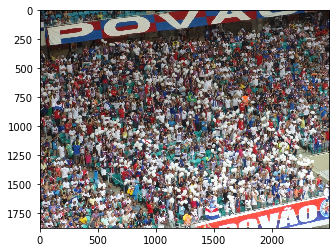

In [74]:
plt.imshow(img)

In [75]:
img = cv2.resize(img, (720, 480), interpolation=cv2.INTER_CUBIC)

In [90]:
img = np.reshape(img, (1, 3, 480, 720))

In [91]:
timg = torch.from_numpy(img).float().cuda()

In [92]:
out = csr_net(timg)

In [93]:
out.sum().item()

-5162.22509765625

In [94]:
count

977.0